In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from backend.data_processing_service import DataProcessingService
from backend.model_service import ModelService, LinRegNN

# CONFIG
log_wandb = False

# Initialize DataProcessingService with has_date_index flag
data_processor = DataProcessingService(seq_length=36, pred_window=12, batch_size=6, has_date_index=True)

# Example data
data_1 = np.loadtxt('data/normalized_apple_prices.csv')
data_2 = data_processor.get_sample_data(length=len(data_1))

# Create date index for one of the series
start_date = '2020-01-01'
end_date = '2020-05-17'
date_index = pd.date_range(start=start_date, end=end_date, freq='D')[:len(data_2)]
data_series = pd.Series(data_1, index=date_index)
data_series_2 = pd.Series(data_2, index=date_index)

# Assuming we have multiple time series, mix of numpy arrays and pandas series
time_series_list = [data_1, data_series_2]

# Process multiple time series
processed_data = data_processor.process_multiple_series(time_series_list)

# Create sequences for each time series
x_data_list, y_data_list = [], []
for data in processed_data:
    x_data, y_data = data_processor.create_sequences(data)
    x_data_list.append(x_data)
    y_data_list.append(y_data)

# Stack sequences from all time series
x_data_combined = np.stack(x_data_list, axis=0)
y_data_combined = np.stack(y_data_list, axis=0)

# Split data into training and test sets
x_train, x_test, y_train, y_test = [], [], [], []
for i in range(x_data_combined.shape[0]):
    x_tr, x_te, y_tr, y_te = data_processor.split_data(x_data_combined[i], y_data_combined[i], train_ratio=0.8)
    x_train.append(x_tr)
    x_test.append(x_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Convert lists to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Print shapes to verify
print("x_train shape:", x_train.shape)  # Should be (2, 42, 36, 4) if 80% split from 53
print("y_train shape:", y_train.shape)  # Should be (2, 42, 12, 4)
print("x_test shape:", x_test.shape)    # Should be (2, 11, 36, 4) if 20% split from 53
print("y_test shape:", y_test.shape)    # Should be (2, 11, 12, 4)

# Convert data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

ms = ModelService()

# Proceed with model training...


x_train shape: (2, 72, 36, 4)
y_train shape: (2, 72, 12, 4)
x_test shape: (2, 19, 36, 4)
y_test shape: (2, 19, 12, 4)


In [ ]:
x_train.shape

torch.Size([72, 36, 4])

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from backend.data_processing_service import DataProcessingService
from backend.model_service import ModelService, LinRegNN
import pandas as pd

#CONFIG
log_wandb = False

# Initialize DataProcessingService
data_processor = DataProcessingService(seq_length=36, pred_window=12, batch_size=6)
data = np.loadtxt('data/normalized_apple_prices.csv')
data_2 = data_processor.get_sample_data(length=len(data))

# Normalize the data
data_normalized, scaler = data_processor.normalize_data(data)


In [16]:
data = data_normalized.squeeze()

<Figure size 1200x600 with 0 Axes>

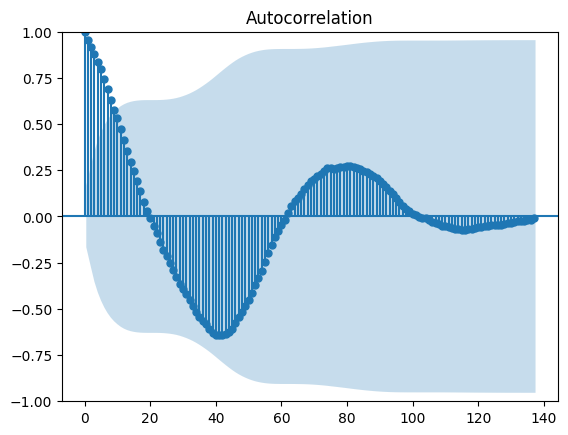

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plot_acf(data, lags=len(data)-1)
plt.show()

In [18]:
start_date = '2020-01-01'
end_date = '2020-05-17'
date_index = pd.date_range(start=start_date, end=end_date, freq='D')[:len(data)]

# Convert data to pandas Series with synthetic date index
data_series = pd.Series(data, index=date_index)

In [19]:
from statsmodels.tsa.seasonal import STL
# STL decomposition
stl = STL(data_series)  # Seasonal parameter can be adjusted based on the data
result = stl.fit()

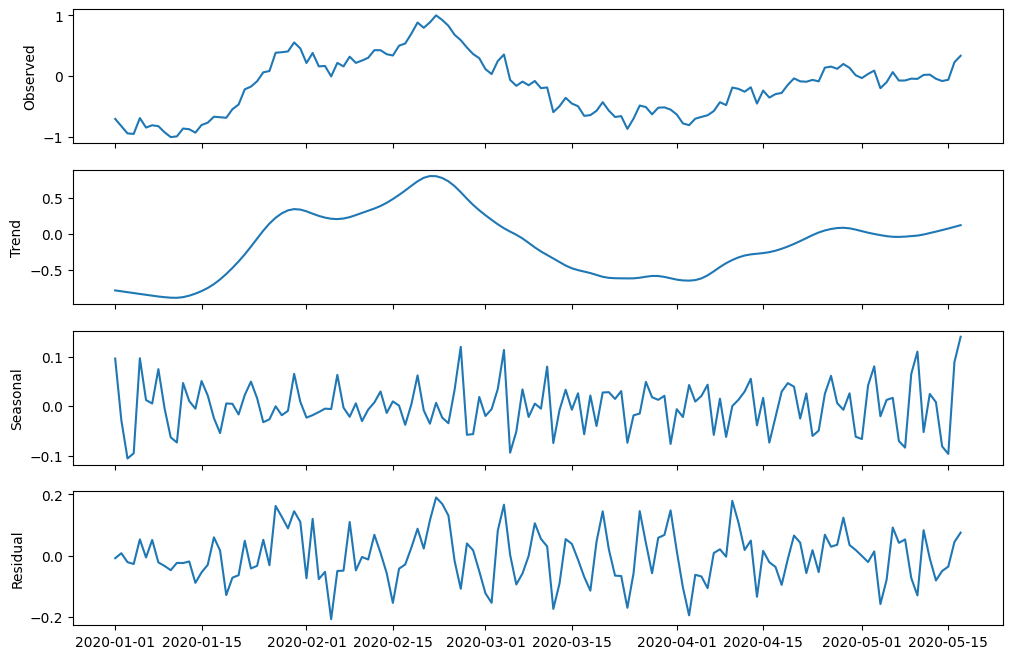

In [20]:
import matplotlib.pyplot as plt
# Plotting the components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
ax1.plot(result.observed)
ax1.set_ylabel('Observed')
ax2.plot(result.trend)
ax2.set_ylabel('Trend')
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(result.resid)
ax4.set_ylabel('Residual')
plt.show()

In [ ]:
ax1.plot(result.observed)
ax2.plot(result.trend)
ax3.plot(result.seasonal)
ax4.plot(result.resid)

In [ ]:
# Create sequences
x_data, y_data = data_processor.create_sequences(data_normalized)

# Split data into training and test sets
x_train, x_test, y_train, y_test = data_processor.split_data(x_data, y_data, train_ratio=0.8)

# Convert data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

ms = ModelService()

In [55]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

torch.Size([72, 36, 1]) torch.Size([72, 12, 1]) torch.Size([19, 36, 1]) torch.Size([19, 12, 1])


In [56]:
# Define the search space for hyperparameters
model_params_space = {
    'input_size': data_processor.seq_length,
    'output_size': data_processor.pred_window
}

# Run hyperparameter optimization
best_hyperparams = ModelService.hyperparameter_optimization(LinRegNN, x_train, y_train, x_test, y_test, model_params_space, max_evals=5)

Epoch [1/10], Loss: 0.0893                           
Epoch [2/10], Loss: 0.8234                           
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

d:\projects\times_fw\.venv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [3/10], Loss: 8.5213                           
Epoch [4/10], Loss: 62.3175                          
Epoch [5/10], Loss: 127.7561                         
Checkpoint saved at backend/checkpoints/test_5.pth   
Epoch [6/10], Loss: 50.3981                          
Epoch [7/10], Loss: 27.0078                          
Epoch [8/10], Loss: 7.7606                           
Epoch [9/10], Loss: 4.2934                           
Epoch [10/10], Loss: 2.3607                          
Checkpoint saved at backend/checkpoints/test_10.pth  
Test Loss: 1.3698                                    
Epoch [1/20], Loss: 21.0813                                                   
Epoch [2/20], Loss: 420.6014                                                  
Epoch [3/20], Loss: 320.6815                                                  
Epoch [4/20], Loss: 14363.1660                                                
Epoch [5/20], Loss: 20716.7883                                                
Checkpoint 

In [57]:
# Extract best hyperparameters
# best_hidden_size = best_hyperparams['model_params']['hidden_size']
best_learning_rate = best_hyperparams['learning_rate']
best_epochs = int(best_hyperparams['epochs'])
best_hyperparams

{'epochs': 15.0, 'learning_rate': 0.015503128972813777}

In [58]:
# Initialize the model with best hyperparameters
model = LinRegNN(data_processor.seq_length, data_processor.pred_window)

In [59]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

# Training loop
if log_wandb:
    ms = ModelService.wandb_login()
    model.train_loop(model, criterion, optimizer, x_train, y_train, epochs=best_epochs, directory = "backend/checkpoints/lr01_", wandb_project="times_fw")
if not log_wandb:
    model.train_loop(model, criterion, optimizer, x_train, y_train, epochs=best_epochs, directory = "backend/checkpoints/lr01_")
    
# Eval
model.evaluation(model, x_test, y_test, criterion)

Epoch [1/15], Loss: 0.0825
Epoch [2/15], Loss: 0.4755
Epoch [3/15], Loss: 3.7934
Epoch [4/15], Loss: 6.1181
Epoch [5/15], Loss: 6.8308
Checkpoint saved at backend/checkpoints/lr01_5.pth
Epoch [6/15], Loss: 1.9794
Epoch [7/15], Loss: 1.3955
Epoch [8/15], Loss: 0.4950
Epoch [9/15], Loss: 0.6376
Epoch [10/15], Loss: 0.3290
Checkpoint saved at backend/checkpoints/lr01_10.pth
Epoch [11/15], Loss: 0.4054
Epoch [12/15], Loss: 0.3112
Epoch [13/15], Loss: 0.7025
Epoch [14/15], Loss: 0.5989
Epoch [15/15], Loss: 1.1161
Checkpoint saved at backend/checkpoints/lr01_15.pth
Test Loss: 1.1499


1.1498610047917617

In [60]:
model.register(model, name="template_test")

Model saved successfully.


In [61]:
from backend.model_service import ModelService
model_service = ModelService()
model = model_service.load_registered_model("backend/models/template_test")

Model loaded successfully.


In [62]:
i = 1
x_new = torch.tensor(x_test[i:i+1], dtype=torch.float32)  # Example of new input data
y_new = torch.tensor(y_test[i:i+1], dtype=torch.float32)
predicted_mean, lower_bound, upper_bound = model.predict_with_confidence_interval(model, x_new, n_samples=100, alpha=0.05)

# Print results
print("Predicted Mean:", predicted_mean)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

Predicted Mean: tensor([[[-0.1558,  0.3530,  0.4590,  0.1235, -0.2893, -0.2247, -0.0152,
           0.3604,  0.5850, -0.2999, -0.7309,  0.0944]]])
Lower Bound: tensor([[[-0.5239, -0.2906, -0.5418, -0.2947, -0.6180, -0.7115, -0.7303,
          -0.2092, -0.1930, -0.7922, -1.4345, -0.7807]]])
Upper Bound: tensor([[[ 0.2917,  1.0290,  1.3939,  0.6958,  0.0823,  0.2260,  0.7203,
           1.0958,  1.4490,  0.4428, -0.0732,  0.9319]]])


C:\Users\Usuario\AppData\Local\Temp\ipykernel_24500\4072349632.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_new = torch.tensor(x_test[i:i+1], dtype=torch.float32)  # Example of new input data
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24500\4072349632.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_new = torch.tensor(y_test[i:i+1], dtype=torch.float32)


In [63]:
predicted_mean = predicted_mean.squeeze() 
lower_bound = lower_bound.squeeze() 
upper_bound = upper_bound.squeeze() 

In [64]:
predicted_mean

tensor([-0.1558,  0.3530,  0.4590,  0.1235, -0.2893, -0.2247, -0.0152,  0.3604,
         0.5850, -0.2999, -0.7309,  0.0944])

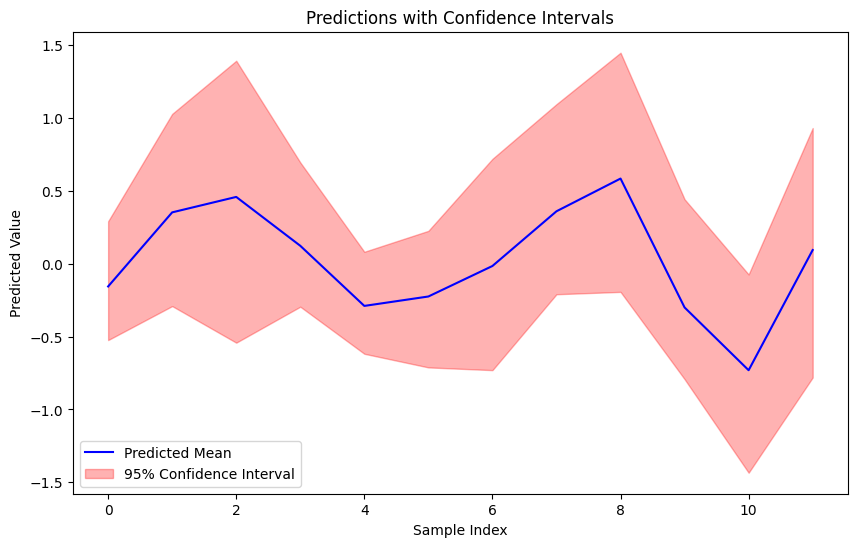

In [65]:
import matplotlib.pyplot as plt
x_indices = np.arange(len(predicted_mean))
plt.figure(figsize=(10, 6))
plt.plot(x_indices, predicted_mean.numpy(), label='Predicted Mean', color='b')
plt.fill_between(x_indices, lower_bound.numpy(), upper_bound.numpy(), color='r', alpha=0.3, label='95% Confidence Interval')
plt.title('Predictions with Confidence Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

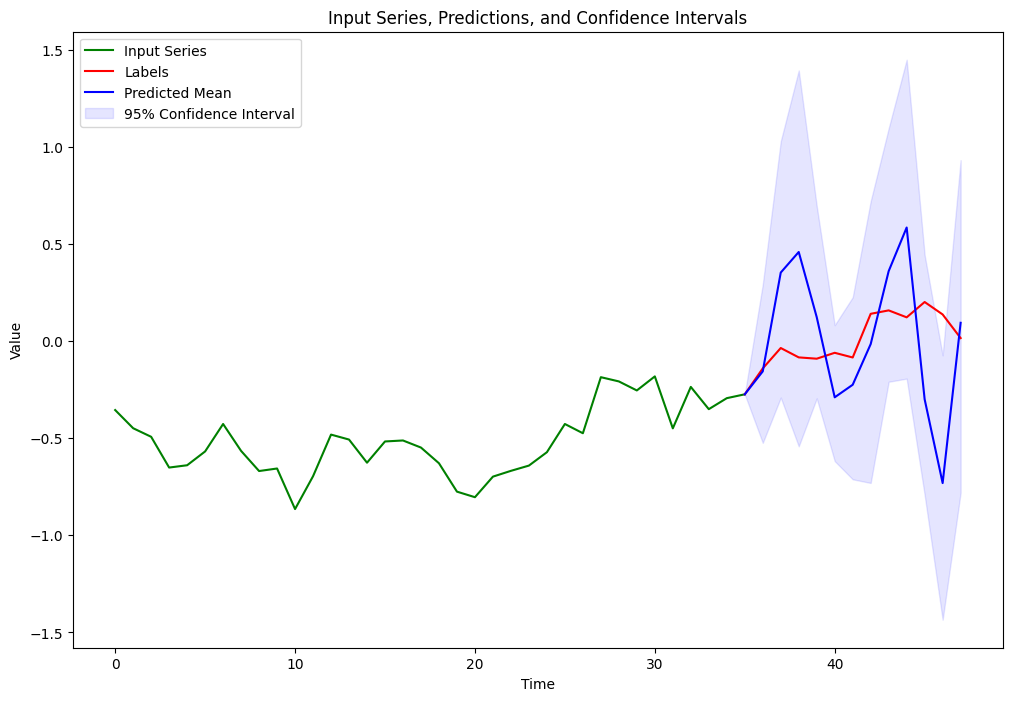

In [66]:
# Plotting the input series, predictions, and confidence intervals
plt.figure(figsize=(12, 8))

# Plot the input series
plt.plot(range(x_new.shape[1]), x_new.numpy().flatten(), label='Input Series', color='g')

# Append the last point of the input series to the predicted mean, lower bound, and upper bound
last_input_point  = x_new[0][-1]
predicted_mean_with_last_point = torch.cat((last_input_point, predicted_mean))
lower_bound_with_last_point = torch.cat((last_input_point, lower_bound))
upper_bound_with_last_point = torch.cat((last_input_point, upper_bound))
y_new_with_last_point = torch.cat((last_input_point, y_new.squeeze()))

input_series_length = x_new.shape[1]

# Plot the label series
predicted_range = range(input_series_length - 1, input_series_length - 1 + len(y_new_with_last_point.flatten()))
plt.plot(predicted_range, y_new_with_last_point.numpy().flatten(), label='Labels', color='r')

# Plot the predicted mean and confidence intervals
predicted_range = range(input_series_length - 1, input_series_length - 1 + len(predicted_mean_with_last_point.flatten()))
plt.plot(predicted_range, predicted_mean_with_last_point.numpy().flatten(), label='Predicted Mean', color='b')
plt.fill_between(predicted_range, lower_bound_with_last_point.numpy().flatten(), upper_bound_with_last_point.numpy().flatten(), color='b', alpha=0.1, label='95% Confidence Interval')

plt.title('Input Series, Predictions, and Confidence Intervals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()